In [1]:
import os
import cv2

In [2]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [3]:
import colour as cl
from scipy import signal as sp
from numpy.linalg import norm

In [4]:
import numpy as np 
import matplotlib.pyplot as plt
import math
import pandas as pd
from pathlib import Path

## Выделение изображения цветовой мишени

### Загрузка файлов (локальная директория)

In [5]:
strip = cv2.imread("imgs/patients/20032024/60/IMG_20240320_121233.jpg")

In [80]:
strip = cv2.imread("imgs/patients/12032024/60/IMG_20240312_120018.jpg")

In [47]:
strip = cv2.imread("imgs/albumin_calibration/01052024/60/IMG_20240501_102503.jpg")

In [14]:
# изображение в RGB
strip_rgb = cv2.cvtColor(strip, cv2.COLOR_BGR2RGB)

In [107]:
strip.shape

(4624, 2600, 3)

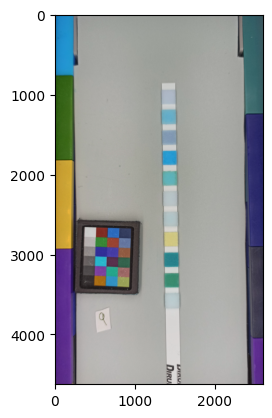

In [6]:
plt.imshow(strip)
plt.show()

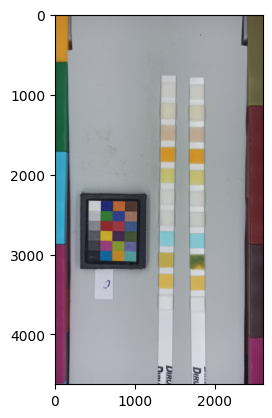

In [16]:
plt.imshow(strip_rgb)
plt.show()

### Функция для выделения фрагмента с цветовой мишенью

In [7]:
# рабочий вариант
def extract_checker(img):
    """
    Функция для извлечения изображения цветовой мишени

    img: снимок тест полоски, BGR, вертикальная ориентация

    Возвращает:
    checker: фрагмент с цветовой мишенью, в RGB
    """
    # преобразование в шкалу серого
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    rct = []
    
    for max_area in [550000, 610000]: # размер колорчекера
        # пороги для определения контура colorchecker
        #for level in [48, 45, 40, 35, 33, 32]:
        for level in [40, 35, 33, 32, 45]:
            ret, thresh = cv2.threshold(gray, level, 255, 0)
            median = cv2.medianBlur(thresh, ksize=17)

            # поиск контуров
            cont, h = cv2.findContours(
                image=median, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE)
    
            # определяем по размеру контур колорчекера
            for i in range(len(cont)):
                if ((500000 < cv2.contourArea(cont[i])) and (max_area > cv2.contourArea(cont[i]))):
                    rct = cont[i]
                    indx = i
            if len(rct) > 0:
                break
        if len(rct) > 0:
            break
        

    sel = img.copy()
    # получаем изображение с наложенным контуром колорчекера
    selected = cv2.drawContours(image=sel, contours=cont, contourIdx=indx, color=(
        0, 255, 0), thickness=15, lineType=cv2.LINE_AA)

    # преобразовываем контур в прямоугольник (бокс)
    rect = cv2.minAreaRect(rct)  # пытаемся вписать прямоугольник
    box = cv2.boxPoints(rect)  # поиск четырех вершин прямоугольника
    box = np.intp(box)  # округление координат
    box_center = (int(rect[0][0]), int(rect[0][1]))

    # вычисление координат двух векторов, являющихся сторонам прямоугольника
    edge1 = np.intp((box[1][0] - box[0][0], box[0][1] - box[1][1]))
    edge2 = np.intp((box[2][0] - box[1][0], box[2][1] - box[1][1]))

    # выясняем какой вектор больше (какая сторона больше)
    usedEdge = edge1
    if cv2.norm(edge2) > cv2.norm(edge1):
        usedEdge = edge2
        tlt = -1 # отрицательный уклон от вертикали
    else:
        tlt = 1 # положительный улон от вертикали
    reference = (0, 1)  # вектор, задающий вертикаль

    # расчет угла поворота    
    # вычисляем угол в радианах между длинной стороной прямоугольника и вертикалью
    a_rad = math.acos((reference[0]*usedEdge[0] + reference[1] *
                       usedEdge[1]) / (cv2.norm(reference) * cv2.norm(usedEdge)))*tlt
    # вычисляем угол в градусах
    angle = a_rad*180.0/math.pi

    # поворачиваем изображение по центру прямоугольника
    # def rotate_around_box(image, angle, box_center):
    rot_mat = cv2.getRotationMatrix2D(box_center, angle, 1.0)
    rotated = cv2.warpAffine(
        img, rot_mat, img.shape[1::-1], flags=cv2.INTER_LINEAR)

    # поворачиваем углы прямоугольника
    corners = np.array([[np.cos(a_rad), -np.sin(a_rad)],
                       [np.sin(a_rad), np.cos(a_rad)]])
    rotated_box = np.intp((box-box_center) @ corners + box_center)

    # вычисляем границы для кропа
    y_top = np.min(np.array([rotated_box[1][1], rotated_box[2, 1]]))
    y_bottom = np.max(np.array([rotated_box[0][1], rotated_box[3, 1]]))
    x_left = np.min(np.array([rotated_box[0][0], rotated_box[1, 0]]))
    x_right = np.max(np.array([rotated_box[2][0], rotated_box[3, 0]]))

    crop = rotated[y_top:y_bottom, x_left:x_right, :]
    checker = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)

    return checker  # gray, thresh, selected, box, angle, rotated, rotated_box

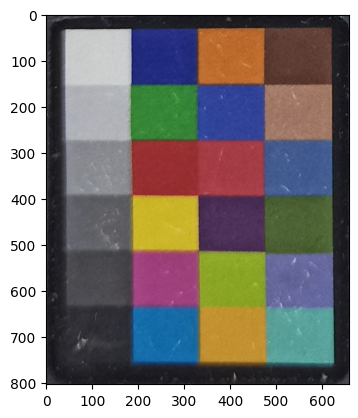

In [8]:
# применяем к изображению, получаем вырезанную цветовую мишень
checker1 = extract_checker(strip)
plt.imshow(checker1)
plt.show()

### Ячейки для корректировки настроек функции выделения цветовой мишени

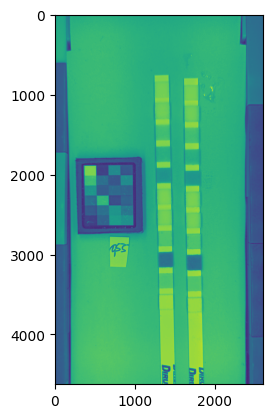

In [51]:
# преобразуем в градации серого
gray = cv2.cvtColor(strip, cv2.COLOR_BGR2GRAY)
plt.imshow(gray)
plt.show()

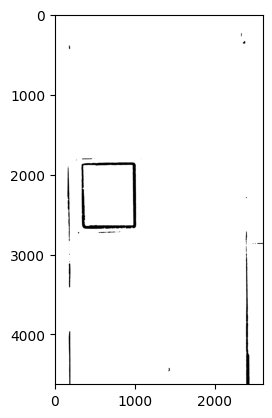

In [59]:
# бинаризация
ret, thresh = cv2.threshold(gray, 45, 255, 0)
median = cv2.medianBlur(thresh, ksize=17)
plt.imshow(median, cmap='gray')
plt.show()

In [56]:
# функция для размывания картинки
def blurImage(image_gray):
    kernel = np.ones((2,2),np.float32)/4                     #Blurring kernel
    #We will skip first line and first column to keep it more simple, it's zeroed out anyway.
    #now for every pixel we change it with the average of 4 pixels(as the kernel): itself, pixel to left
    #pixel up, and pixel up-left. It drifts some edges one pixel to bottom-down, but it does not matter as
    #long as we use edged picture for the future work
    res=sp.convolve2d(image_gray,kernel,mode='same')
    
    return np.round(res).astype(np.uint8)

In [60]:
# поиск контуров
cont, h = cv2.findContours(
        image=median, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE)

In [61]:
# отбор контура по размерам
for i in range(len(cont)):
        if ((500000 < cv2.contourArea(cont[i])) and (580000 > cv2.contourArea(cont[i]))):
            rct = cont[i]
            indx = i
            print(cv2.contourArea(cont[i]))
            print(indx)

556004.0
25


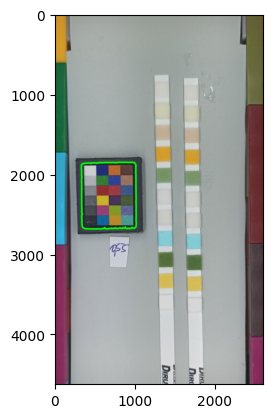

In [62]:
# визуализация найденного контура
tr = strip.copy()
tr = cv2.cvtColor(tr, cv2.COLOR_BGR2RGB)
tv = cv2.drawContours(image=tr, contours=cont, contourIdx= indx, color=(0, 255, 0), thickness=20, lineType=cv2.LINE_AA)
plt.imshow(tv)
plt.show()

## Выделение значений RGB на снимке цветовой мишени

### Границы зон цветовой мишени

In [9]:
# коэффициенты для выделения зон цветовой мишени
# подобраны вручную. При умножении на длину и ширину изображения задают границы фрагментов
# для каждой из 24 зон колорчекера
# первые два коэффициента - правая и левая границы
# третий и четвертый коэффициенты - верхняя и нижняя границы

coeff = np.zeros(shape=(24, 4))

coeff[0] = [0.78,0.88,0.09,0.15]
coeff[1] = [0.78,0.88,0.24,0.30]
coeff[2] = [0.78,0.88,0.39,0.45]
coeff[3] = [0.78,0.88,0.54,0.60]
coeff[4] = [0.78,0.88,0.69,0.75]
coeff[5] = [0.78,0.88,0.84,0.90]

coeff[6] = [0.56,0.66,0.09,0.15]
coeff[7] = [0.56,0.66,0.24,0.30]
coeff[8] = [0.56,0.66,0.39,0.45]
coeff[9] = [0.56,0.66,0.54,0.60]
coeff[10] = [0.56,0.66,0.69,0.75]
coeff[11] = [0.56,0.66,0.84,0.90]

coeff[12] = [0.34,0.44,0.09,0.15]
coeff[13] = [0.34,0.44,0.24,0.30]
coeff[14] = [0.34,0.44,0.39,0.45]
coeff[15] = [0.34,0.44,0.54,0.60]
coeff[16] = [0.34,0.44,0.69,0.75]
coeff[17] = [0.34,0.44,0.84,0.90]

coeff[18] = [0.13,0.23,0.09,0.15]
coeff[19] = [0.13,0.23,0.24,0.30]
coeff[20] = [0.13,0.23,0.39,0.45]
coeff[21] = [0.13,0.23,0.54,0.60]
coeff[22] = [0.13,0.23,0.69,0.75]
coeff[23] = [0.15,0.23,0.84,0.90]

Пример выделения одной отдельной цветовой зоны в колорчекере (без использования функции):

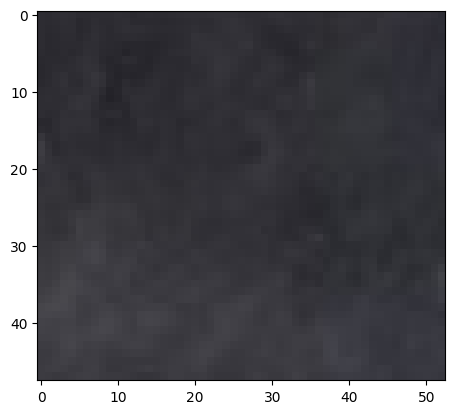

In [11]:
# размеры изображения колорчекера:
y = checker1.shape[0]
x = checker1.shape[1]

# границы зоны 18:
check18_xleft = int(x*0.15)
check18_xright = int(x*0.23)
check18_ytop = int(y*0.84)
check18_ybottom = int(y*0.90)

# обрезаем изображение:
chart18 = checker1[check18_ytop:check18_ybottom, check18_xleft:check18_xright, :]
plt.imshow(chart18)
plt.show()

In [19]:
# исключения (проверялась корректировка с исключением некоторых зон)
exceptions = [] # зоны мишени, которые исключаются из расчетов

### Функция для выделения значений RGB из изображения цветовой мишени

In [12]:
def extract_values(img, exceptions=[]):
    """
    Функция для извлечения средних значений RGB 
    для колорчекера на снимке
    Границы зон цветовой мишени заданы в массиве coeff с коэффициентами

    img - обрезанный снимок colorchecker в RGB
    exceptions - номера зон, которые будут исключены
    """
    # массив для значений RGB из 24 зон цветовой мишени
    values = np.zeros(shape=(24, 3))
    # coef = np.delete(coeff, exceptions, 0) # исключаем выбранные зоны
    # размеры изображения мишени
    y = img.shape[0]
    x = img.shape[1]

    # для каждой из 24 зон:
    for i in range(24):

        # вычисляем границы фрагментов в цветовой зоне
        xleft = int(x*coeff[i][0])
        xright = int(x*coeff[i][1])
        ytop = int(y*coeff[i][2])
        ybottom = int(y*coeff[i][3])
        # вырезаем фрагмент цветовой зоны
        check = img[ytop:ybottom, xleft:xright, :]
        # вычисляем средние значения для RGB
        values[i] = np.mean(check, axis=(1, 0))
    
    values = np.delete(values, exceptions, 0) # исключаем выбранные зоны

    return values

Выделение значений RGB цветовой мишени на снимке:

In [13]:
# выделим значения RGB для зон цветовой мишени
rgb_values = extract_values(checker1)
rgb_values

array([[  94.43213384,   61.37152778,   52.37152778],
       [ 159.19573284,  117.9004329 ,  100.73840445],
       [  66.21180556,   91.64772727,  144.61016414],
       [  76.77588384,   98.80713384,   52.64457071],
       [ 101.15955473,  102.94526902,  154.53494125],
       [  88.47727273,  161.30650253,  154.26736111],
       [ 188.86805556,  107.47664141,   44.96212121],
       [  48.8135436 ,   67.24242424,  153.24335189],
       [ 164.45486111,   59.64930556,   69.03977273],
       [  77.56218434,   49.61710859,   89.8677399 ],
       [ 138.41620284,  165.2690167 ,   36.30735931],
       [ 194.99463384,  145.09690657,   48.72316919],
       [  33.48011364,   43.30587121,  128.30334596],
       [  54.20995671,  135.17810761,   56.14131107],
       [ 151.9592803 ,   46.47979798,   49.99179293],
       [ 203.53188131,  182.50441919,   40.80460859],
       [ 159.39239332,   64.51144094,  124.86456401],
       [  19.42266414,  107.82544192,  167.80965909],
       [ 203.92676768,  205.

In [39]:
len(rgb_values)

24

## Определение цветовых отличий от референса
### Таблица с данными цветовой мишени

In [14]:
# таблица для цветовой мишени в RGB
ref_chart_RGB = np.array([[114, 79, 66],  # 1
                          [194, 142, 124],  # 2
                          [91, 120, 154],  # 3
                          [91, 108, 64],  # 4
                          [131, 127, 173],  # 5
                          [98, 189, 170],  # 6
                          [223, 122, 49],  # 7
                          [68, 88, 166],  # 8
                          [195, 79, 94],  # 9
                          [93, 60, 105],  # 10
                          [156, 186, 59],  # 11
                          [229, 162, 44],  # 12
                          [38, 62, 146],  # 13
                          [61, 146, 68],  # 14
                          [177, 53, 57],  # 15
                          [235, 199, 26],  # 16
                          [190, 79, 146],  # 17
                          [1, 135, 165],  # 18
                          [240, 241, 236],  # 19
                          [202, 203, 203],  # 20
                          [162, 164, 164],  # 21
                          [121, 121, 120],  # 22
                          [83, 85, 85],  # 23
                          [51, 51, 50]  # 24
                          ])

In [45]:
# таблица для цветовой мишени в CIELAB
ref_chart_Lab = np.array([[37.1, 14, 13.96],  # 1
                          [63.98, 18.67, 17.77],  # 2
                          [49.22, -3.82, -22.22],  # 3
                          [43.3, -12.86, 22.4],  # 4
                          [54.8, 9.42, -24.27],  # 5
                          [70.76, -32.24, 0.85],  # 6
                          [62.15, 36.24, 55.49],  # 7
                          [38.87, 11.28, -45.38],  # 8
                          [50, 48.51, 16.43],  # 9
                          [30.72, 21.47, -20.67],  # 10
                          [71.36, -23.42, 57.64],  # 11
                          [71.99, 18.44, 66.29],  # 12
                          [28.34, 15.19, -50.08],  # 13
                          [53.94, -39.26, 32.92],  # 14
                          [42.15, 50.09, 28.01],  # 15
                          [81.7, 2.47, 78.67],  # 16
                          [50.55, 50.81, -14.16],  # 17
                          [50.22, -30.02, -27.44],  # 18
                          [95.08, -1.15, 2.32],  # 19
                          [81.65, -0.57, 0.05],  # 20
                          [67.12, -0.73, -0.25],  # 21
                          [50.73, -0.09, 0.21],  # 22
                          [35.99, -0.63, -0.38],  # 23
                          [21.12, -0.14, 0.31]  # 24
                          ])

In [34]:
# координаты условий освещения
illuminantD50 = np.array([0.34570, 0.35850])
illuminantD65 = np.array([0.31272, 0.32903])

Преобразование заданных таблиц в XYZ

Преобразование таблицы RGB в XYZ

In [37]:
# преобразуем таблицу в xyz из RGB, используя параметры для D50
ref_chart_XYZ_from_RGB = cl.sRGB_to_XYZ(ref_chart_RGB/255, illuminantD50)
# выведем первый элемент
ref_chart_XYZ_from_RGB[0], len(ref_chart_XYZ_from_RGB)

(array([ 0.1113067 ,  0.09682749,  0.04856997]), 24)

Преобоазование таблицы CIE Lab в XYZ

In [99]:
# преобразуем таблицу в xyz из CIE Lab, используя параметры для D50
ref_chart_XYZ_from_Lab = cl.Lab_to_XYZ(ref_chart_Lab, illuminantD50)
# выведем первый элемент
ref_chart_XYZ_from_Lab[0], len(ref_chart_XYZ_from_Lab)

(array([ 0.11052786,  0.09592009,  0.04817983]), 24)

Преобразование величин на снимке колорчекера в XYZ

In [100]:
# преобразуем величины для колорчекера в XYZ
xyz_values = cl.sRGB_to_XYZ(rgb_values/255, illuminantD50)
# выведем первый элемент
xyz_values[0], len(xyz_values)

(array([ 0.06307487,  0.05383858,  0.02641873]), 24)

### Вычисление угловых расстояний

Функция для вычисления угловых расстояний:

In [16]:
# функция для вычисления углов между векторами в 2D array
def angle_distance(a,b):
    distances = np.zeros(shape=24 - len(exceptions))
    for i in range(24 - len(exceptions)):
        distances[i] = np.arccos(np.dot(a[i],b[i])/(norm(a[i])*norm(b[i])))
    # возвращаем массив с углами и среднее значение    
    return distances, np.mean(distances)
        

Расстояния для XYZ, вычисленных по таблице CIE Lab

In [102]:
# вычислим углы между соответствующими векторами для таблицы, пересчитанной из CIE Lab
init_dist, mean_dist = angle_distance(xyz_values, ref_chart_XYZ_from_Lab)

In [103]:
init_dist, mean_dist

(array([ 0.0123946 ,  0.01139294,  0.171565  ,  0.01954535,  0.10752848,
         0.05144704,  0.01049676,  0.09933862,  0.0528468 ,  0.01401046,
         0.03057713,  0.0193259 ,  0.04702411,  0.03031078,  0.0055215 ,
         0.01967734,  0.02219377,  0.13871503,  0.01415842,  0.02656529,
         0.03146721,  0.04567221,  0.03701351,  0.06921631]),
 0.045333524975143986)

Расстояния для XYZ, вычисленных по таблице RGB

In [17]:
# вычислим углы между соответствующими векторами 
init_dist_2, mean_dist_2 = angle_distance(xyz_values, ref_chart_XYZ_from_RGB)
init_dist_2, mean_dist_2

NameError: name 'xyz_values' is not defined

Проблемные зоны на колорчекере: 2 и 17 (начиная с 0) 

Расстояния для пространства RGB (таблица RGB из документации колорчекера)

In [20]:
# вычислим углы между соответствующими векторами 
init_dist_rgb, mean_dist_rgb = angle_distance(rgb_values, ref_chart_RGB)
init_dist_rgb, mean_dist_rgb

(array([ 0.02829765,  0.00760706,  0.11171062,  0.04537954,  0.06308331,
         0.0300004 ,  0.0213239 ,  0.09468674,  0.05587573,  0.01444849,
         0.07156542,  0.0484186 ,  0.07425564,  0.04023343,  0.0079077 ,
         0.06985811,  0.01339659,  0.14705799,  0.01065646,  0.01384984,
         0.01726162,  0.02725823,  0.02678792,  0.05980099]),
 0.045863414450722673)

In [21]:
rad_angles=init_dist_rgb*180/3.14

In [22]:
rad_angles

array([ 1.62215801,  0.43607339,  6.4037934 ,  2.60137511,  3.61624044,
        1.71976824,  1.22238905,  5.42790206,  3.20306714,  0.82825713,
        4.10247623,  2.77558849,  4.25669276,  2.30637476,  0.45330753,
        4.00460501,  0.76795736,  8.43007588,  0.61087962,  0.79393975,
        0.98951984,  1.56257373,  1.53561298,  3.42808241])

## Корректировка изображений относительно референса

### Определение матрицы преобразования для пространства XYZ

Определим матрицу для преобразования относительно таблицы XYZ из CIE Lab

#### Метод наименьших квадратов, XYZ:

Вычислим откорректированные значения для колорчекера и вычислим угловые расстояния

In [108]:
# вычисляем матрицу для преобразования, используя значения от снимка колорчекера xyz_values
# и данные из напечатанной таблицы ref_chart_XYZ_from_Lab
model = np.linalg.lstsq(xyz_values, ref_chart_XYZ_from_Lab, rcond=None)[0]
# вычисляем преобразованные значения xyz для изображения колорчекера
xyz_pred = np.matmul(xyz_values, model)
# вычислим углы между векторами в вычисленных значениях и в таблице
corrected_dist, mean_corrected_dist = angle_distance(xyz_pred, ref_chart_XYZ_from_Lab)
corrected_dist, mean_corrected_dist

(array([ 0.02291684,  0.01577576,  0.09168218,  0.02851758,  0.0369535 ,
         0.01998742,  0.03138359,  0.01101308,  0.04157855,  0.06051038,
         0.03800171,  0.02635484,  0.07173278,  0.05844627,  0.02967726,
         0.01540497,  0.02536972,  0.06652693,  0.01367193,  0.00465748,
         0.00176597,  0.01281111,  0.00518111,  0.03397091]),
 0.031828827465014579)

#### Метод наименьших квадратов с полиномиальным преобразованием, XYZ:

In [109]:
# преобразуем значения xyz снимка колорчекера в полиномиальные
xyz_values_poly = PolynomialFeatures(degree=2).fit_transform(xyz_values)
# вычислим матрицу преобразования для полиномиальных данных
model_poly = np.linalg.lstsq(xyz_values_poly, ref_chart_XYZ_from_Lab, rcond=None)[0]
# вычисляем преобразованные значения xyz для изображения колорчекера
xyz_pred_poly = np.matmul(xyz_values_poly, model_poly)
# вычислим углы между векторами в вычисленных значениях и в таблице
corrected_dist_poly, mean_corrected_dist_poly = angle_distance(xyz_pred_poly, ref_chart_XYZ_from_Lab)
corrected_dist_poly, mean_corrected_dist_poly

(array([ 0.02018955,  0.00716348,  0.07331117,  0.02751753,  0.0177221 ,
         0.00372322,  0.00688123,  0.01953499,  0.02727325,  0.03864514,
         0.01236424,  0.00584339,  0.06181296,  0.02044887,  0.02310224,
         0.01025368,  0.01937238,  0.02349837,  0.00137383,  0.00632662,
         0.00715936,  0.016983  ,  0.01955825,  0.06820128]),
 0.022427504803340065)

#### Линейная регрессия. XYZ:

In [110]:
lr = LinearRegression()
lr.fit(xyz_values, ref_chart_XYZ_from_Lab)
xyz_pred_lr = lr.predict(xyz_values)
# вычислим углы между векторами в вычисленных значениях и в таблице
corrected_dist_lr, mean_corrected_dist_lr = angle_distance(xyz_pred_lr, ref_chart_XYZ_from_Lab)
corrected_dist_lr, mean_corrected_dist_lr

(array([ 0.00735097,  0.01527234,  0.07421706,  0.01662589,  0.03192433,
         0.01734614,  0.03191961,  0.0284102 ,  0.03629407,  0.09703753,
         0.03145616,  0.02668427,  0.11761272,  0.03963258,  0.03744354,
         0.01531243,  0.02654758,  0.06161049,  0.01074699,  0.00262487,
         0.00210628,  0.00390173,  0.01395716,  0.00019797]),
 0.031093038227822233)

#### Линейная регрессия с полиномиальным преобразованием, XYZ:

In [111]:
# преобразуем значения xyz снимка колорчекера в полиномиальные
xyz_values_poly = PolynomialFeatures(degree=2).fit_transform(xyz_values)
lr_poly = LinearRegression()
lr_poly.fit(xyz_values_poly, ref_chart_XYZ_from_Lab)
xyz_pred_lr_poly = lr_poly.predict(xyz_values_poly)
# вычислим углы между векторами в вычисленных значениях и в таблице
corrected_dist_lr_poly, mean_corrected_dist_lr_poly = angle_distance(xyz_pred_lr_poly, ref_chart_XYZ_from_Lab)
corrected_dist_lr_poly, mean_corrected_dist_lr_poly

(array([ 0.02018955,  0.00716348,  0.07331117,  0.02751753,  0.0177221 ,
         0.00372322,  0.00688123,  0.01953499,  0.02727325,  0.03864514,
         0.01236424,  0.00584339,  0.06181296,  0.02044887,  0.02310224,
         0.01025368,  0.01937238,  0.02349837,  0.00137383,  0.00632662,
         0.00715936,  0.016983  ,  0.01955825,  0.06820128]),
 0.022427504803335205)

### Определение матрицы преобразования для пространства RGB
#### Метод наименьших квадратов, RGB

In [23]:
# вычисляем матрицу для преобразования, используя значения от снимка колорчекера xyz_values
# и данные из напечатанной таблицы ref_chart_XYZ_from_Lab
model_rgb = np.linalg.lstsq(rgb_values, ref_chart_RGB, rcond=None)[0]
# вычисляем преобразованные значения rgb для изображения колорчекера
rgb_pred = np.matmul(rgb_values, model_rgb)
# вычислим углы между векторами в вычисленных значениях и в таблице
corrected_dist_rgb, mean_corrected_dist_rgb = angle_distance(rgb_pred, ref_chart_RGB)
corrected_dist_rgb, mean_corrected_dist_rgb

(array([ 0.03799506,  0.0190877 ,  0.07133787,  0.04932715,  0.03676058,
         0.00952321,  0.0224923 ,  0.05036383,  0.05605485,  0.02964338,
         0.07700325,  0.04713569,  0.02496181,  0.06328334,  0.01343167,
         0.0674039 ,  0.02017167,  0.10149677,  0.01466913,  0.01226403,
         0.00900966,  0.00195565,  0.01255286,  0.03114551]),
 0.036627953687450233)

#### Метод наименьших квадратов с полиномиальным преобразованием для RGB

In [39]:
# преобразуем значения rgb снимка колорчекера в полиномиальные
rgb_values_poly = PolynomialFeatures(degree=2).fit_transform(rgb_values)
# вычислим матрицу преобразования для полиномиальных данных
model_rgb_poly = np.linalg.lstsq(rgb_values_poly, ref_chart_RGB, rcond=None)[0]
# вычисляем преобразованные значения xyz для изображения колорчекера
rgb_pred_poly = np.matmul(rgb_values_poly, model_rgb_poly)
# вычислим углы между векторами в вычисленных значениях и в таблице
corrected_dist_rgb_poly, mean_corrected_dist_rgb_poly = angle_distance(rgb_pred_poly, ref_chart_RGB)
corrected_dist_rgb_poly, mean_corrected_dist_rgb_poly

(array([ 0.03473395,  0.02577561,  0.05213726,  0.01935593,  0.01808708,
         0.0136753 ,  0.01830959,  0.03222325,  0.04038255,  0.01687617,
         0.04915706,  0.00833496,  0.02024903,  0.03933991,  0.03905387,
         0.03399843,  0.01231638,  0.04477242,  0.00203943,  0.00526885,
         0.01142804,  0.00909474,  0.01938075,  0.05019783]),
 0.025674516427440053)

In [41]:
rgb_values_poly.shape

(24, 10)

In [45]:
model_rgb_poly

array([[ -1.98523086e+01,  -1.39923775e+01,  -8.17887898e+00],
       [  1.40853856e+00,   2.18213380e-01,   3.26450511e-01],
       [  2.01873125e-01,   1.07802544e+00,   1.25803674e-02],
       [ -5.02795829e-02,   1.32151893e-01,   9.41581518e-01],
       [ -1.47383271e-03,  -6.03930446e-04,  -1.28558761e-03],
       [  1.20477017e-03,   2.08640898e-04,  -1.54311222e-03],
       [  5.71282562e-04,  -8.44568767e-04,   1.86987293e-03],
       [ -1.42358767e-03,  -2.46099265e-04,   1.32204566e-03],
       [ -1.38223577e-03,   1.27871589e-04,  -1.73325760e-03],
       [  9.74058380e-04,   3.18451111e-04,   7.74246763e-04]])

In [43]:
model_rgb_poly.shape

(10, 3)

#### Линейная регрессия, RGB

In [26]:
lr_rgb = LinearRegression()
lr_rgb.fit(rgb_values, ref_chart_RGB)
rgb_pred_lr = lr_rgb.predict(rgb_values)
# вычислим углы между векторами в вычисленных значениях и в таблице
corrected_dist_lr_rgb, mean_corrected_dist_lr_rgb = angle_distance(rgb_pred_lr, ref_chart_RGB)
corrected_dist_lr_rgb, mean_corrected_dist_lr_rgb

(array([ 0.03406009,  0.01914943,  0.07188142,  0.05240208,  0.03639795,
         0.01004153,  0.02242854,  0.05171926,  0.05553216,  0.03048669,
         0.07681501,  0.0471377 ,  0.02106181,  0.06588891,  0.01453349,
         0.06741776,  0.02010419,  0.10030261,  0.01457446,  0.01221174,
         0.00918036,  0.00319509,  0.00877579,  0.03392926]),
 0.03663447307194477)

In [27]:
lr_rgb.coef_

array([[ 1.22610875, -0.07413696,  0.03309196],
       [ 0.01152866,  1.05785284,  0.10181105],
       [ 0.0561357 , -0.05049242,  1.10975039]])

#### Линейная регрессия с полиномиальным преобразованием для RGB

In [37]:
# преобразуем значения rgb снимка колорчекера в полиномиальные
rgb_values_poly = PolynomialFeatures(degree=2).fit_transform(rgb_values)
lr_rgb_poly = LinearRegression()
lr_rgb_poly.fit(rgb_values_poly, ref_chart_RGB)
rgb_pred_lr_poly = lr_rgb_poly.predict(rgb_values_poly)
# вычислим углы между векторами в вычисленных значениях и в таблице
corrected_dist_lr_rgb_poly, mean_corrected_dist_lr_rgb_poly = angle_distance(rgb_pred_lr_poly, ref_chart_RGB)
corrected_dist_lr_rgb_poly, mean_corrected_dist_lr_rgb_poly

(array([ 0.03473395,  0.02577561,  0.05213726,  0.01935593,  0.01808708,
         0.0136753 ,  0.01830959,  0.03222325,  0.04038255,  0.01687617,
         0.04915706,  0.00833496,  0.02024903,  0.03933991,  0.03905387,
         0.03399843,  0.01231638,  0.04477242,  0.00203943,  0.00526885,
         0.01142804,  0.00909474,  0.01938075,  0.05019783]),
 0.025674516427433292)

In [35]:
rgb_values_poly[:2]

array([[  1.00000000e+00,   9.44321338e+01,   6.13715278e+01,
          5.23715278e+01,   5.79544432e+03,   4.94555512e+03,
          3.21412067e+03],
       [  1.00000000e+00,   1.59195733e+02,   1.17900433e+02,
          1.00738404e+02,   1.87692458e+04,   1.60371241e+04,
          1.18771015e+04]])

In [38]:
rgb_values_poly[:2]

array([[  1.00000000e+00,   9.44321338e+01,   6.13715278e+01,
          5.23715278e+01,   8.91742790e+03,   5.79544432e+03,
          4.94555512e+03,   3.76646442e+03,   3.21412067e+03,
          2.74277692e+03],
       [  1.00000000e+00,   1.59195733e+02,   1.17900433e+02,
          1.00738404e+02,   2.53432814e+04,   1.87692458e+04,
          1.60371241e+04,   1.39005121e+04,   1.18771015e+04,
          1.01482261e+04]])

In [29]:
lr_rgb_poly.coef_

array([[  0.00000000e+00,   1.40853856e+00,   2.01873125e-01,
         -5.02795829e-02,  -1.47383271e-03,   1.20477017e-03,
          5.71282562e-04,  -1.42358767e-03,  -1.38223577e-03,
          9.74058380e-04],
       [  0.00000000e+00,   2.18213380e-01,   1.07802544e+00,
          1.32151893e-01,  -6.03930446e-04,   2.08640898e-04,
         -8.44568767e-04,  -2.46099265e-04,   1.27871589e-04,
          3.18451111e-04],
       [  0.00000000e+00,   3.26450511e-01,   1.25803674e-02,
          9.41581518e-01,  -1.28558761e-03,  -1.54311222e-03,
          1.86987293e-03,   1.32204566e-03,  -1.73325760e-03,
          7.74246763e-04]])

### Корректировка изображений

Функция для корректировки значений вне диапазона

In [32]:
def warp_extremes(values, thresholds=[5,250]):
    values = values.astype(np.float32)
    overshoot = values[values>thresholds[1]]
    undershoot = values[values<thresholds[0]]
    
    if len(overshoot)>0:
        diff = overshoot-thresholds[1]
        diff[diff>20]=20
        o_values = thresholds[1]+((255-thresholds[1])*(1-(1/(np.exp(0.5*diff)))))
        values[values>thresholds[1]] = np.round(o_values)
    if len(undershoot)>0:
        diff = thresholds[0]-undershoot
        diff[diff>20]=20
        u_values = thresholds[0]-(thresholds[0]*(1-(1/(np.exp(0.5*diff)))))
        values[values<thresholds[0]] = np.round(u_values)
    
    
    return values.astype(np.uint8)

Составим функцию для преобразования изображений с использованием полученной модели

In [35]:
# функция для преобразования изображения
def image_correction(img, model, mode='xyz', method = 'lstsq', illuminant=illuminantD50, poly=False):
    """
    Функция для преобразования изображения по референсу
    img - исходное изображение в RGB
    model - модель для преобразования
    mode - выбор пространства для преобразования:
        'xyz' - расчеты в пространстве XYZ
         'rgb' - расчеты в пространстве RGB
    method - выбор модели для пересчета:
        lstsq - наименьшие квадраты
        linear - линейная регрессия
        pls - partial least squares
    illuminant - выбор режима освещения исходной картинки, illuminantD50 или illuminantD60
    poly - полиномиальное преобразование
    """
    sz = img.shape[:2]  # определяем размер
    img_ = img.reshape(-1, 3)  # разворачиваем

    # выбор, в каком пространстве идет пересчет
    if mode == 'xyz':  # для пространства XYZ
        img_xyz = cl.sRGB_to_XYZ(img_/255, illuminant)

        # выбор полиномиального преобразования
        if poly:
            img_xyz = PolynomialFeatures(degree=2).fit_transform(img_xyz)
        
        # выбор модели преобразования
        if method == 'lstsq': # метод наименьших квадратов
            img_xyz_corrected = np.matmul(img_xyz, model)
        else: # линейная регрессия и pls
            img_xyz_corrected = model.predict(img_xyz)
        
        img_rgb_corrected = (cl.XYZ_to_sRGB(
            img_xyz_corrected)*255).astype(np.uint8)

    if mode == 'rgb':  # для пространства RGB
        if poly:  # выбор модели с полиномиальным преобразованием
            img_ = PolynomialFeatures(degree=2).fit_transform(img_)
        
        # выбор модель для преобразования
        if method == 'lstsq':   # метод наименьших квадратов 
            img_rgb_corrected = np.matmul(img_, model).astype(np.uint8)
        else: # линейная регрессия и pls
            img_rgb_corrected = model.predict(img_)
    img_rgb_corrected = img_rgb_corrected.reshape(sz[0], sz[1], 3)
    img_rgb_corrected = warp_extremes(img_rgb_corrected, thresholds=[5, 250])

    return img_rgb_corrected

Составим функцию для вывода исходного и преобразованного изображений

In [36]:
# функция для вывода исходного и преобразованного изображения
def show_image(orig_img, corrected_img):
        
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    ax[0].imshow(orig_img)
    ax[0].set_title('Original Image')
    ax[1].imshow(corrected_img)
    ax[1].set_title('Corrected Image')
    plt.show()

Применим преобразование к изображению колорчекера и к исходному изображению в целом

#### Вычисления в XYZ, метод наименьших квадратов

Для колорчекера, с D50:

In [41]:
checker_corrected = image_correction(checker1, model, 'xyz', 'lstsq', illuminantD50, poly = False)
show_image(checker1, checker_corrected)

NameError: name 'model' is not defined

С D65:

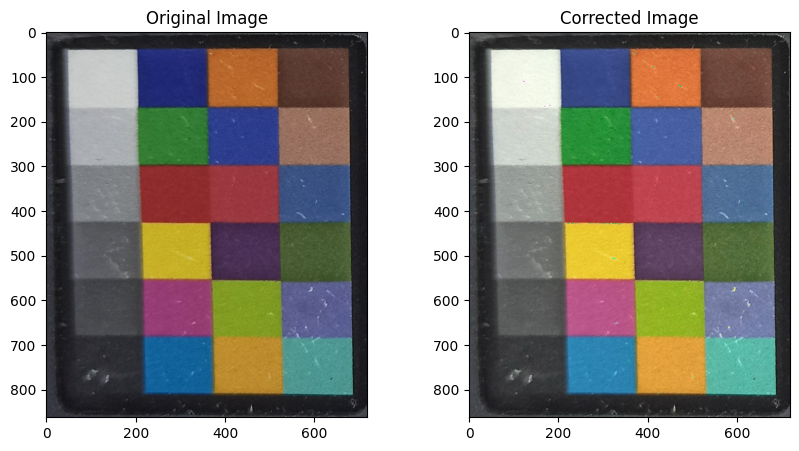

In [64]:
checker_corrected = image_correction(checker1, model, 'xyz', 'lstsq', illuminantD65, poly = False)
show_image(checker1, checker_corrected)

Для изображения в целом, D50

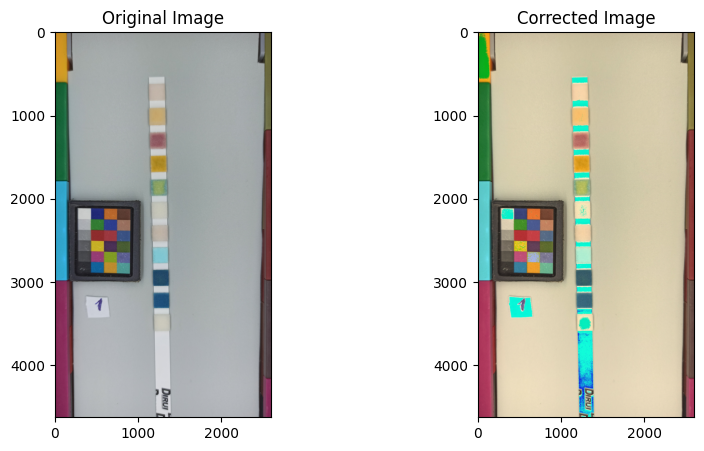

In [65]:
strip_corrected = image_correction(strip_rgb, model, 'xyz', 'lstsq', illuminantD50, poly = False)
show_image(strip_rgb, strip_corrected)

Для изображения в целом, D65

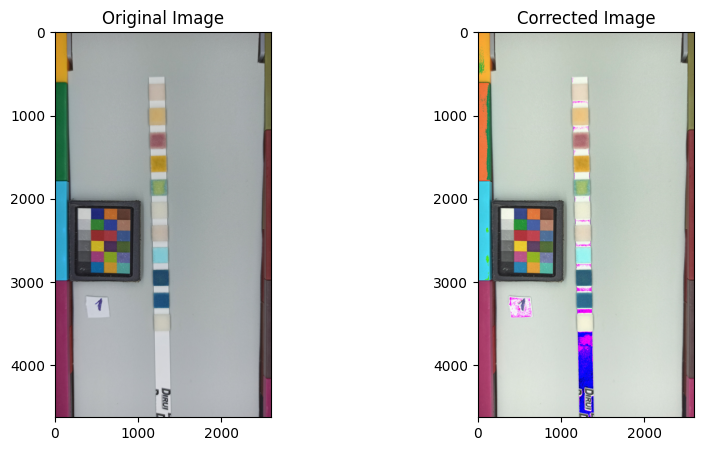

In [66]:
strip_corrected = image_correction(strip_rgb, model, 'xyz', 'lstsq', illuminantD65, poly = False)
show_image(strip_rgb, strip_corrected)

#### Вычисления в XYZ, полиномиальные признаки, метод наименьших квадратов

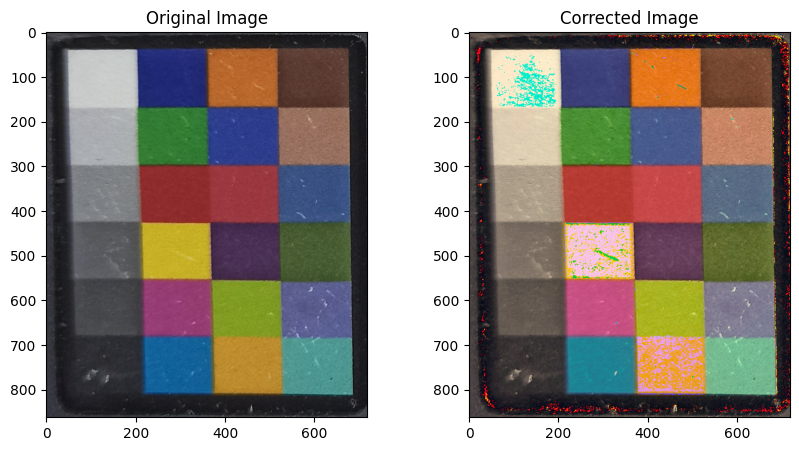

In [67]:
checker_corrected_poly = image_correction(checker1, model_poly, 'xyz','lstsq', illuminantD50, poly=True)
show_image(checker1, checker_corrected_poly)

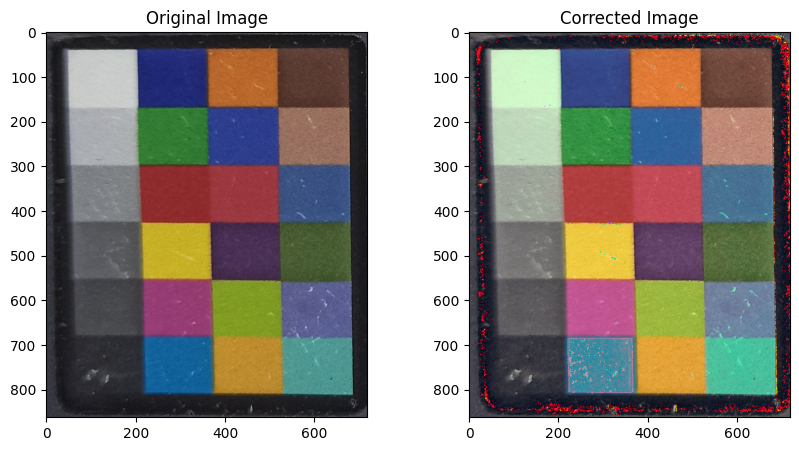

In [68]:
checker_corrected_poly = image_correction(checker1, model_poly, 'xyz','lstsq', illuminantD65, poly=True)
show_image(checker1, checker_corrected_poly)

Для изображения в целом, D65

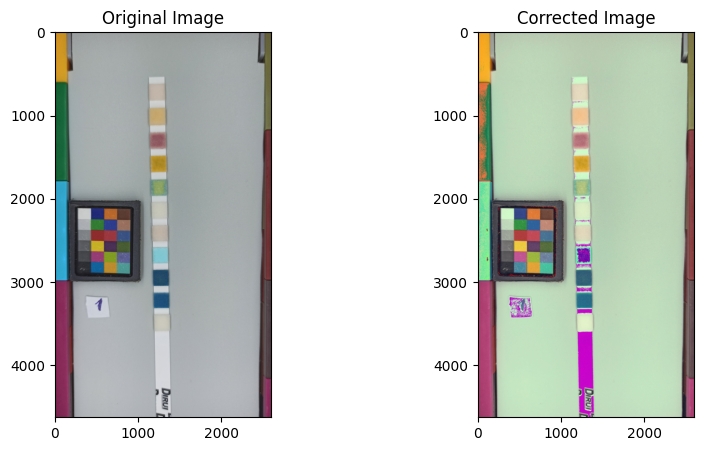

In [69]:
strip_corrected = image_correction(strip_rgb, model_poly, 'xyz','lstsq', illuminantD65, poly = True)
show_image(strip_rgb, strip_corrected)

#### Вычисления в XYZ, линейная регрессия

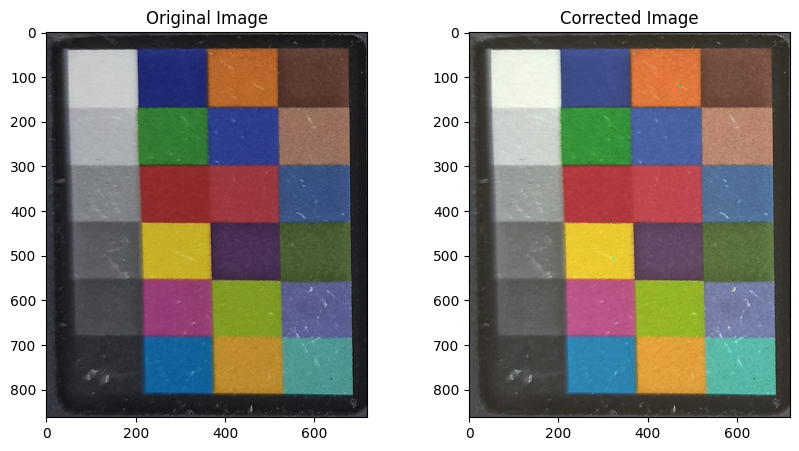

In [70]:
#колорчекер
checker_corrected = image_correction(checker1, lr, 'xyz', 'linear', illuminantD65, poly = False)
show_image(checker1, checker_corrected)

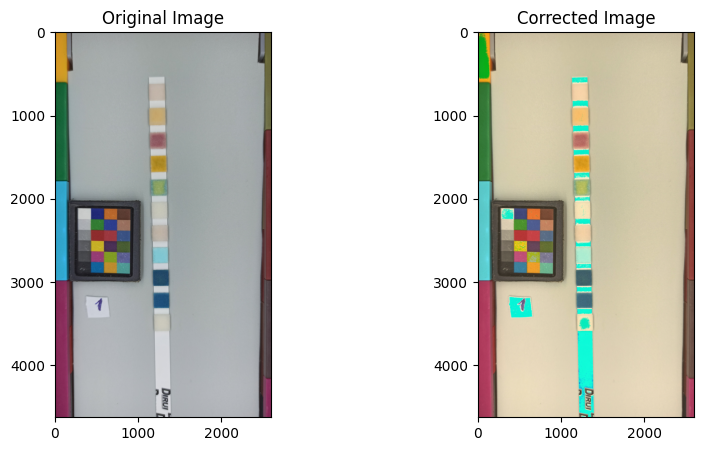

In [71]:
# весь снимок
strip_corrected = image_correction(strip_rgb, lr, 'xyz', 'linear', illuminantD50, poly = False)
show_image(strip_rgb, strip_corrected)

#### Вычисления в XYZ, полиномиальные признаки, линейная регрессия

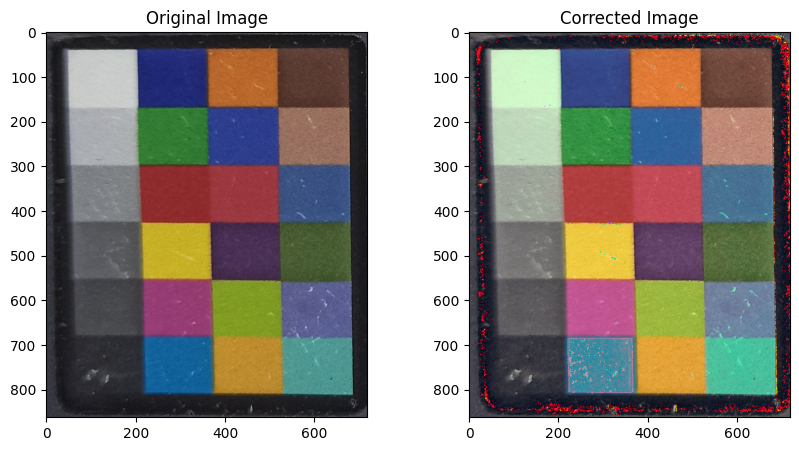

In [72]:
# колорчекер
checker_corrected = image_correction(checker1, lr_poly, 'xyz', 'linear', illuminantD65, poly = True)
show_image(checker1, checker_corrected)

#### Вычисления в RGB, линейная регрессия

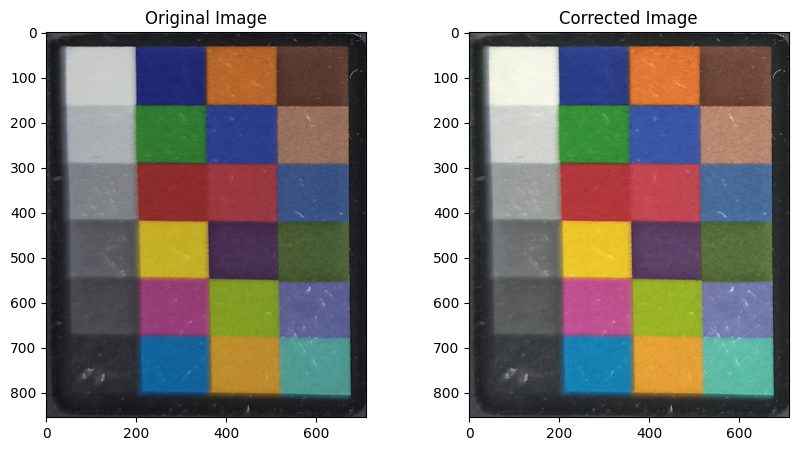

In [120]:
# колорчекер
checker_corrected = image_correction(checker1, lr_rgb, 'rgb', 'linear', illuminantD65, poly = False)
show_image(checker1, checker_corrected)

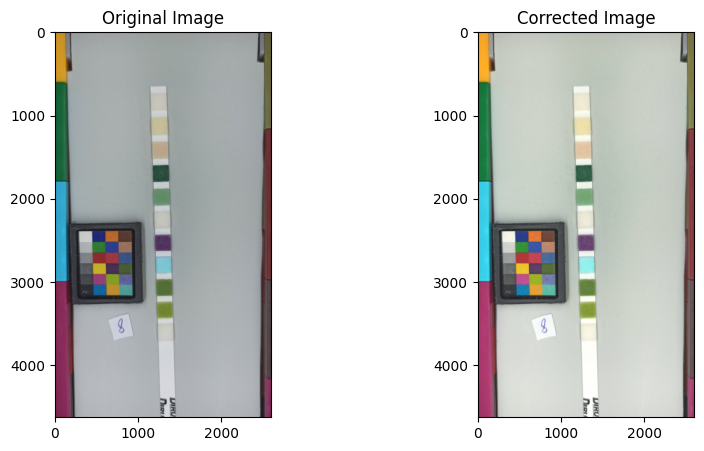

In [121]:
# весь снимок
strip_corrected = image_correction(strip_rgb, lr_rgb, 'rgb', 'linear', illuminantD50, poly = False)
show_image(strip_rgb, strip_corrected)

#### Вычисления в RGB, линейная регрессия, полиномиальные значения

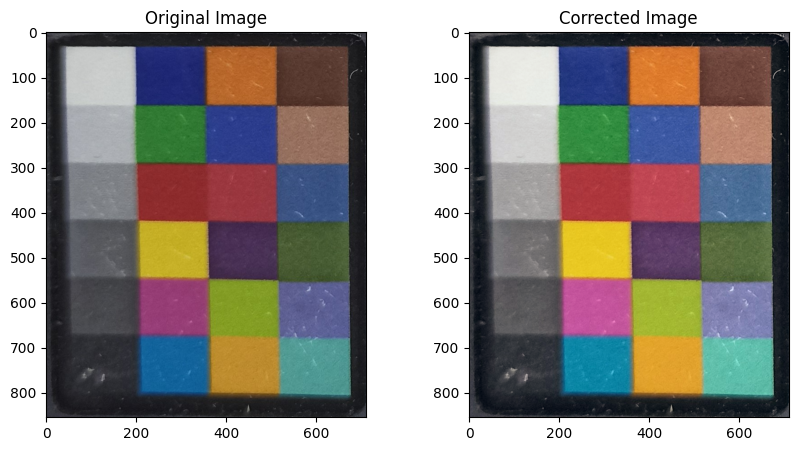

In [122]:
# колорчекер
checker_corrected = image_correction(checker1, lr_rgb_poly, 'rgb', 'linear', illuminantD65, poly = True)
show_image(checker1, checker_corrected)

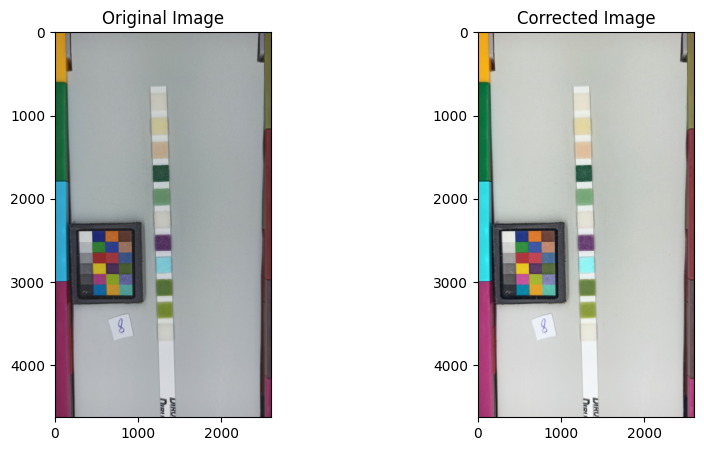

In [123]:
# весь снимок
strip_corrected = image_correction(strip_rgb, lr_rgb_poly, 'rgb', 'linear', illuminantD50, poly = True)
show_image(strip_rgb, strip_corrected)

#### Вычисления в RGB, метод наименьших квадратов

Для изображения колорчекера:

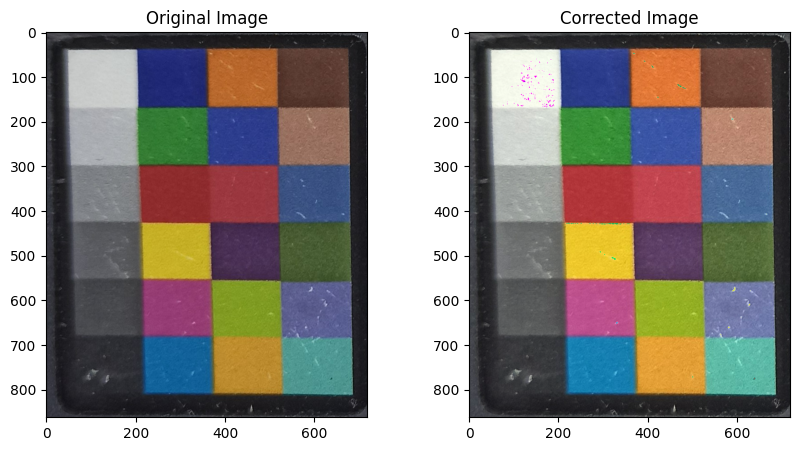

In [77]:
# значение illuminant не важно, так как преобразование в xyz не проводится
checker_corrected = image_correction(checker1, model_rgb, 'rgb','lstsq', illuminantD50, poly = False)
show_image(checker1, checker_corrected)

Для снимка в целом

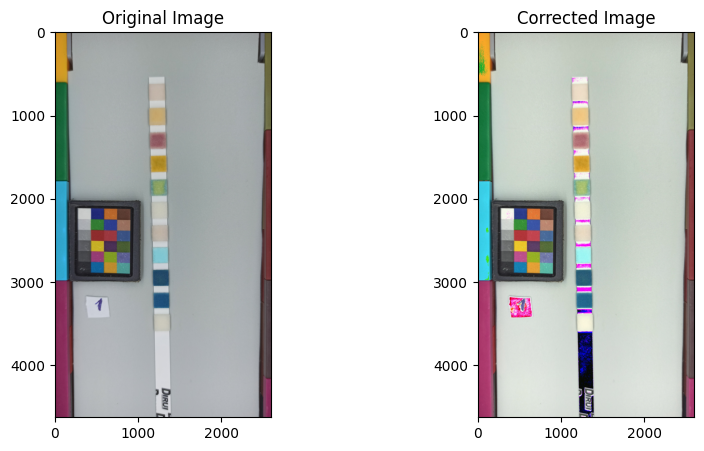

In [78]:
strip_corrected = image_correction(strip_rgb, model_rgb, 'rgb', 'lstsq', illuminantD50, poly = False)
show_image(strip_rgb, strip_corrected)

#### Вычисления в RGB, метод наименьших квадратов, полиномиальные значения

Для изображения колорчекера

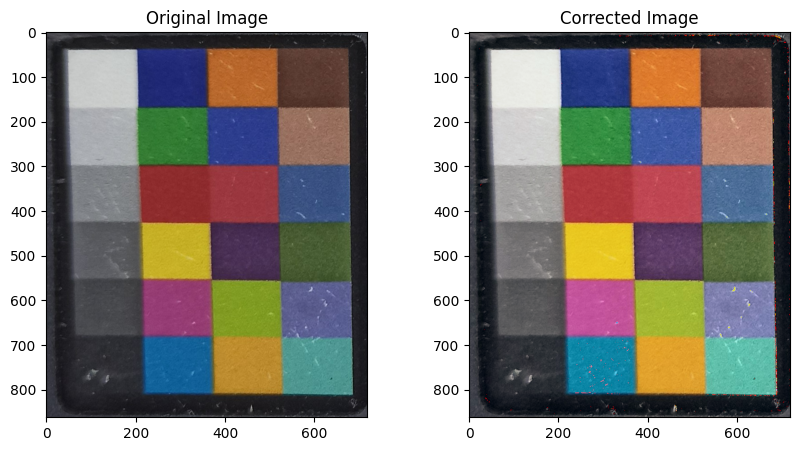

In [79]:
# значение illuminant не важно, так как преобразование в xyz не проводится
checker_corrected = image_correction(checker1, model_rgb_poly, 'rgb', 'lstsq', illuminantD50, poly = True)
show_image(checker1, checker_corrected)

Для снимка в целом

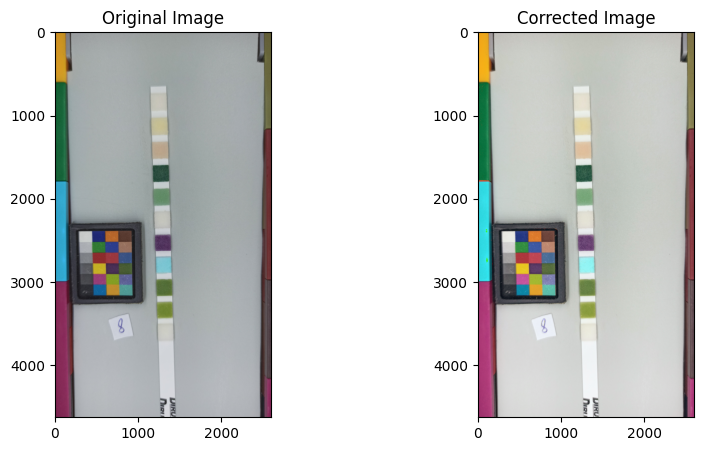

In [502]:
strip_corrected = image_correction(strip_rgb, model_rgb_poly, 'rgb', 'lstsq', illuminantD50, poly = True)
show_image(strip_rgb, strip_corrected)

## Корректировка снимков тест-полосок

In [71]:
# укажем путь к файлам и получим список файлов:
path = "imgs/albumin_calibration/01052024/60/"
files = os.listdir(path)

In [69]:
corrected_path = "imgs/patients/26032024/60_corrected/"

In [158]:
# укажем путь к файлам и получим список файлов:
path = "imgs/glucose/10032024/60/"
files = os.listdir(path)

In [65]:
len(files)

54

In [72]:
files = files[24:39]
len(files)

15

In [69]:
files[0]

'IMG_20240501_102503.jpg'

In [217]:
files[5]

'IMG_20240325_120541.jpg'

In [311]:
fls = []
for i in [15]:
    fls.append(files[i])
fls

['IMG_20240325_122113.jpg']

In [40]:
# создадим в директории дня новую директорую для файлов с коррекцией
corrected_path = os.path.join(str(Path(path).parents[0]), (Path(path).parts[-1] + '_corrected'))
os.mkdir(corrected_path)

In [41]:
# объединенная функция для корректировки цветовых координат
def color_correction(path, filename, new_path):
    """
    Функция для корректировки цвета по референсной цветовой мишени на снимке
    path - путь к файлам
    filename - имя исходного файла
    new_path - путь для сохранения корректированных файлов
    """
    img = cv2.imread(path + filename) # читаем файл
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # переводим в RGB
    checker = extract_checker(img) # извлекаем изображение колорчекера
    
    rgb_values = extract_values(checker) # извлекаем значения RGB на снимке
    
    # преобразуем величины RGB в полиномиальные
    rgb_values_poly = PolynomialFeatures(degree=2).fit_transform(rgb_values)
    # обучаем линейную регрессию
    lr_rgb_poly = LinearRegression()
    lr_rgb_poly.fit(rgb_values_poly, ref_chart_RGB)
    
    # выполняем цветовую коррекцию, переводим в BGR, сохраняем файл
    img_corrected = image_correction(img_rgb, lr_rgb_poly, 'rgb', 'linear', illuminantD65, poly = True)
    img_bgr = cv2.cvtColor(img_corrected, cv2.COLOR_RGB2BGR)
    cv2.imwrite(os.path.join(new_path ,filename), img_bgr)
    
    return img_corrected    

### Корректировка изображений:

In [73]:
# выполним коррекцию цвета для всех файлов в директории
for item in files:
    img1 = color_correction(path, item, corrected_path)